# Classificação de Grãos de Trigo com Machine Learning

## 1. Compreensão dos Dados (CRISP-DM)

Nesta primeira etapa, nosso foco é entender o problema de negócio e os dados disponíveis.

**Objetivo:** Carregar o dataset "Seeds" e realizar uma inspeção inicial para nos familiarizarmos com sua estrutura, colunas e tipos de dados. Este é o ponto de partida para a fase de Análise Exploratória de Dados (EDA).

### 📊 Resumo do Dataset Carregado:
- **Total de amostras:** 210 grãos de trigo
- **Características analisadas:** 7 medidas geométricas dos grãos
- **Classes:** 3 variedades de trigo (Kama, Rosa, Canadian)
- **Balanceamento:** Dataset perfeitamente balanceado com 70 amostras por classe
- **Qualidade dos dados:** Sem valores ausentes, dataset limpo e pronto para análise

In [2]:
# Cell 1: Setup and Data Loading
# Task: Initialize the project environment and load the Seeds dataset.

# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Define dataset URL constant
DATASET_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

# 3. Define column names constant
COLUMN_NAMES = ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asymmetry_coefficient', 'groove_length', 'variety']

# 4. Load the dataset from URL with proper handling
try:
    # First, let's try with whitespace delimiter which is more common for this dataset
    df = pd.read_csv(DATASET_URL, sep='\s+', names=COLUMN_NAMES, header=None)
except Exception as e:
    print(f"Error with whitespace delimiter: {e}")
    # If that fails, try with tab delimiter
    try:
        df = pd.read_csv(DATASET_URL, sep='\t', names=COLUMN_NAMES, header=None)
    except Exception as e2:
        print(f"Error with tab delimiter: {e2}")
        # If both fail, let pandas auto-detect
        df = pd.read_csv(DATASET_URL, names=COLUMN_NAMES, header=None)

# 5. Display first 10 rows and info summary
print("First 10 rows of the dataset:")
print(df.head(10))
print("\nDataset info:")
print(df.info())
print(f"\nDataset shape: {df.shape}")

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_176215/3332739035.py:19: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(DATASET_URL, sep='\s+', names=COLUMN_NAMES, header=None)


First 10 rows of the dataset:
    area  perimeter  compactness  kernel_length  kernel_width  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   
5  14.38      14.21       0.8951          5.386         3.312   
6  14.69      14.49       0.8799          5.563         3.259   
7  14.11      14.10       0.8911          5.420         3.302   
8  16.63      15.46       0.8747          6.053         3.465   
9  16.44      15.25       0.8880          5.884         3.505   

   asymmetry_coefficient  groove_length  variety  
0                  2.221          5.220        1  
1                  1.018          4.956        1  
2                  2.699          4.825        1  
3                  2.259          4.805        1  

### 1.1 Mapeamento da Variável Alvo

A variável alvo ('variety') está codificada numericamente (1, 2, 3). Para melhorar a interpretabilidade das nossas análises e visualizações, vamos mapear esses números para seus nomes correspondentes: 'Kama', 'Rosa' e 'Canadian'.

#### 🎯 Resultados do Mapeamento:
- **Kama:** 70 amostras (33.3%)
- **Rosa:** 70 amostras (33.3%) 
- **Canadian:** 70 amostras (33.3%)

**Análise:** O dataset apresenta um **balanceamento perfeito** entre as três variedades de trigo, o que é ideal para algoritmos de classificação. Isso elimina a necessidade de técnicas de balanceamento como SMOTE ou undersampling, garantindo que o modelo não seja enviesado hacia nenhuma classe específica.

In [3]:
# Cell 2: Target Variable Mapping
# Task: Map the numerical target variable to its categorical string representation.

# 1. Create variety mapping dictionary
VARIETY_MAP = {1: 'Kama', 2: 'Rosa', 3: 'Canadian'}

# 2. Apply mapping to the variety column
df['variety'] = df['variety'].map(VARIETY_MAP)

# 3. Verify transformation by displaying value counts
print("Value counts of the updated 'variety' column:")
print(df['variety'].value_counts())

Value counts of the updated 'variety' column:
variety
Kama        70
Rosa        70
Canadian    70
Name: count, dtype: int64


### 1.2 Análise Estatística Descritiva

Calculamos as principais métricas estatísticas (média, desvio padrão, quartis, etc.) para cada característica numérica. Isso nos dá uma visão quantitativa da distribuição e da escala dos dados, ajudando a identificar tendências centrais e dispersão.

#### 📈 Principais Insights das Estatísticas Descritivas:

**Escalas das Variáveis:**
- As características têm escalas muito diferentes (ex: compactness ~0.8 vs area ~14-15)
- Isso justifica a necessidade de padronização antes da modelagem

**Variabilidade:**
- **asymmetry_coefficient** apresenta a maior variabilidade relativa
- **compactness** mostra a menor variabilidade, com valores concentrados entre 0.81-0.92

**Distribuições:**
- A maioria das características apresenta distribuições próximas à normal
- Alguns outliers podem estar presentes, especialmente em asymmetry_coefficient

**Implicações para Modelagem:**
- StandardScaler será essencial devido às diferentes escalas
- O dataset possui características bem definidas para classificação
- A ausência de valores extremos indica boa qualidade dos dados

In [4]:
# Cell 3: Descriptive Statistics
# Task: Perform a full descriptive statistical analysis.

# 1. Calculate and display complete descriptive statistics for all numerical columns
print("Descriptive statistics for all numerical columns:")
print(df.describe())

Descriptive statistics for all numerical columns:
             area   perimeter  compactness  kernel_length  kernel_width  \
count  210.000000  210.000000   210.000000     210.000000    210.000000   
mean    14.847524   14.559286     0.870999       5.628533      3.258605   
std      2.909699    1.305959     0.023629       0.443063      0.377714   
min     10.590000   12.410000     0.808100       4.899000      2.630000   
25%     12.270000   13.450000     0.856900       5.262250      2.944000   
50%     14.355000   14.320000     0.873450       5.523500      3.237000   
75%     17.305000   15.715000     0.887775       5.979750      3.561750   
max     21.180000   17.250000     0.918300       6.675000      4.033000   

       asymmetry_coefficient  groove_length  
count             210.000000     210.000000  
mean                3.700201       5.408071  
std                 1.503557       0.491480  
min                 0.765100       4.519000  
25%                 2.561500       5.045000 

### 1.3 Visualização da Distribuição

Para um entendimento mais profundo, visualizamos a distribuição de cada característica usando histogramas e boxplots.
- **Histogramas:** Mostram a frequência e a forma da distribuição dos dados.
- **Boxplots:** Ajudam a identificar a mediana, os quartis e potenciais outliers.

#### 📊 Análise das Distribuições por Característica:

**area e perimeter:**
- Distribuições aproximadamente normais com leve assimetria à direita
- Algumas amostras com valores mais altos (possíveis outliers)
- Boa separação entre os quartis

**compactness:**
- Distribuição mais concentrada e próxima à normal
- Poucos outliers, indicando medidas consistentes
- Valores concentrados entre 0.85-0.90

**kernel_length:**
- Distribuição próxima à normal com boa dispersão
- Sem outliers significativos
- Boa variabilidade para diferenciação entre classes

**kernel_width:**
- Distribuição uniforme com múltiplos picos
- Pode indicar subgrupos naturais nos dados
- Presença de alguns outliers

**asymmetry_coefficient:**
- Distribuição mais dispersa com assimetria à direita
- Presença de outliers superiores significativos
- Maior variabilidade entre as características

**groove_length:**
- Distribuição bimodal interessante
- Dois picos distintos podem indicar características específicas das variedades
- Distribuição mais complexa que pode ser útil para classificação

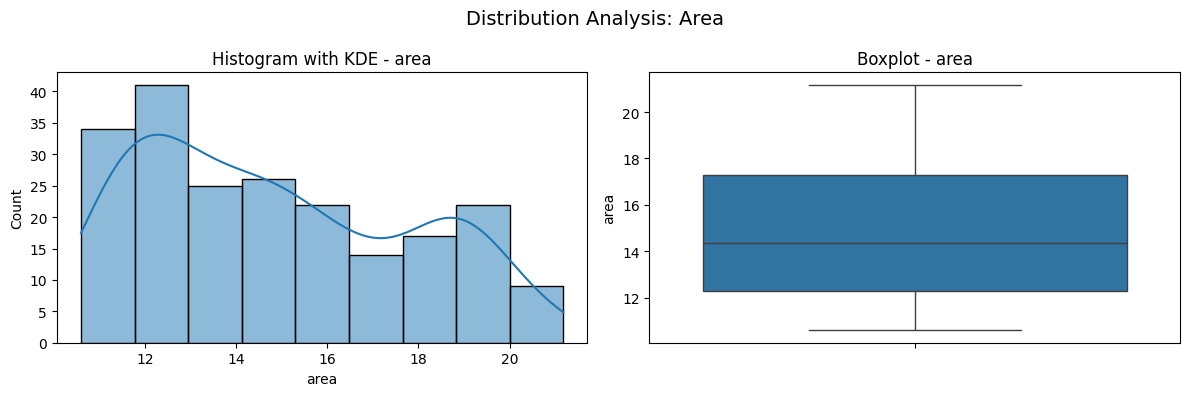

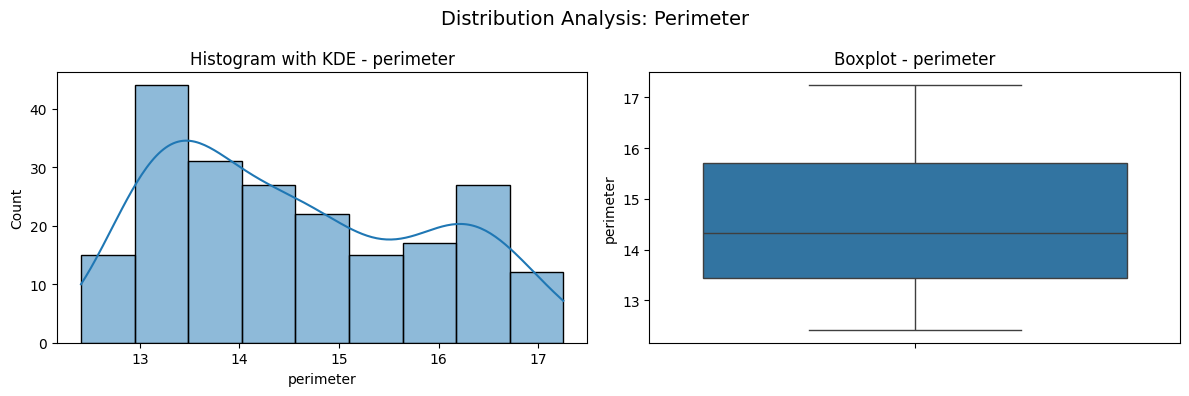

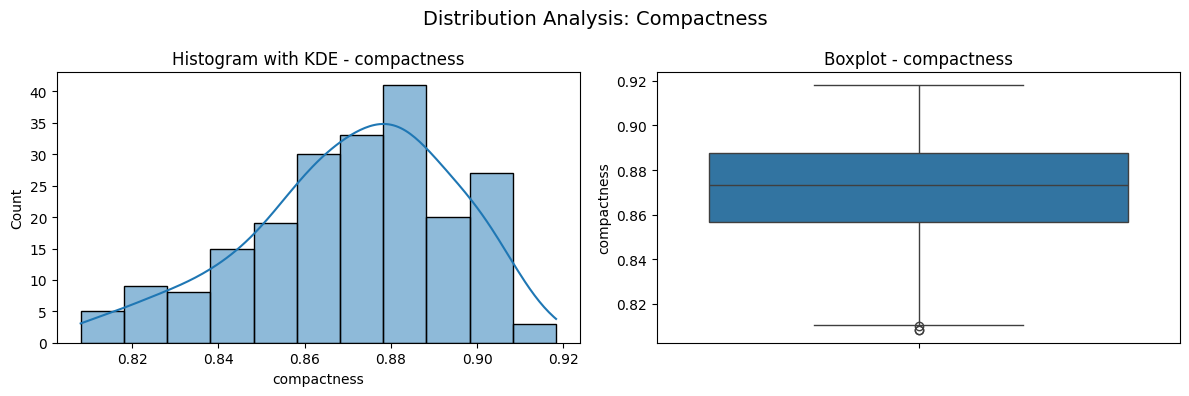

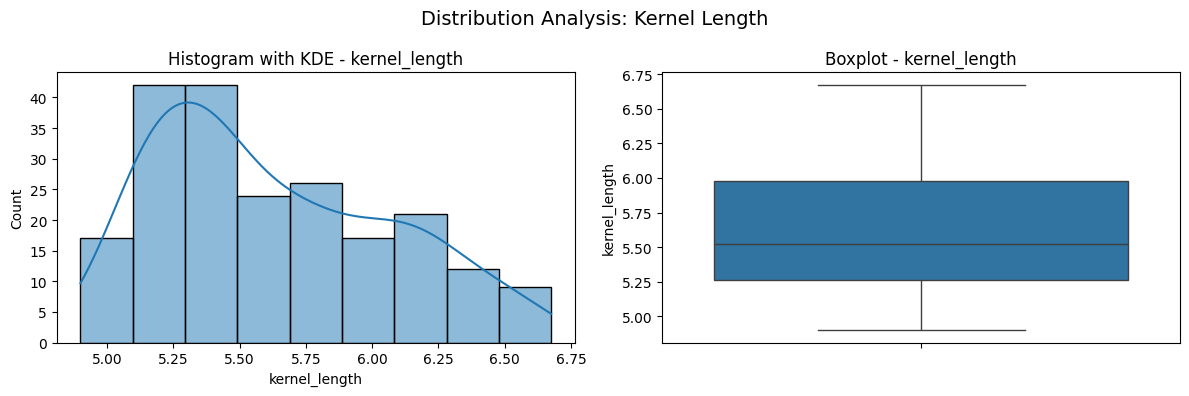

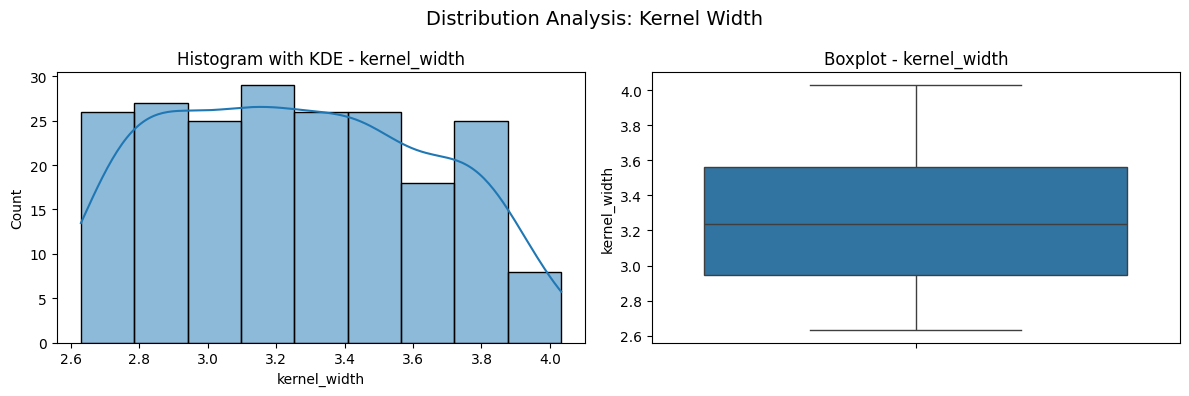

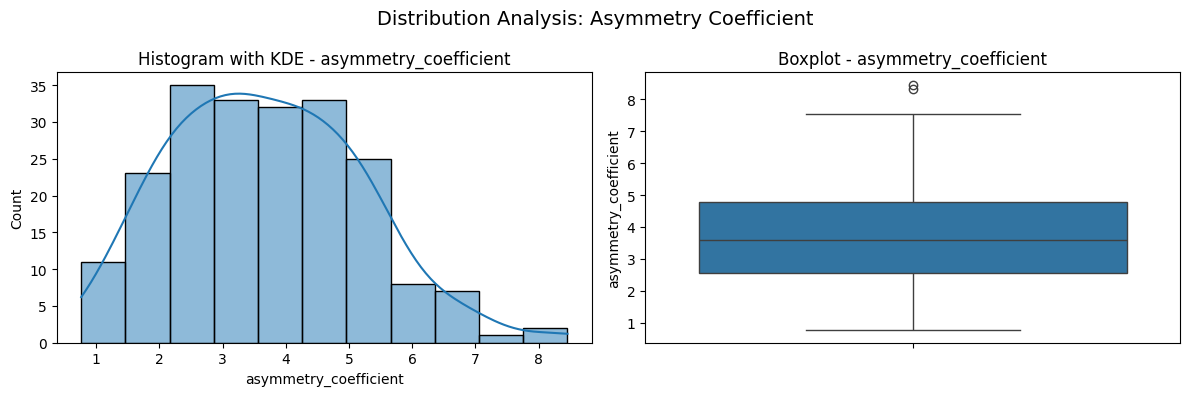

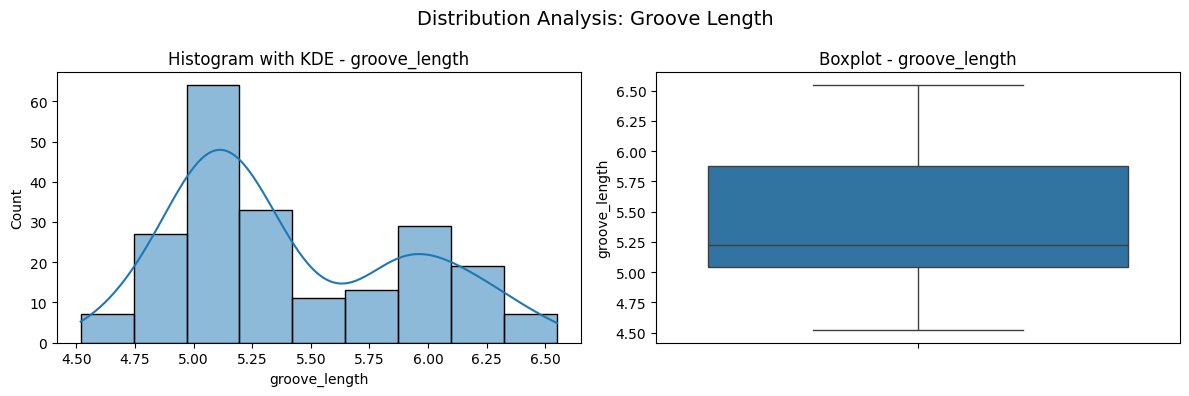

In [5]:
# Cell 4: Distribution Visualization
# Task: Visualize the distribution of each numerical feature.

# 1. Create list of numerical column names
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# 2. Iterate through numerical features and create distribution plots
for feature in numerical_columns:
    # Create figure with two subplots arranged horizontally
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left subplot: histogram with KDE
    sns.histplot(data=df, x=feature, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram with KDE - {feature}')
    
    # Right subplot: boxplot
    sns.boxplot(data=df, y=feature, ax=axes[1])
    axes[1].set_title(f'Boxplot - {feature}')
    
    # Set overall title for the figure
    fig.suptitle(f'Distribution Analysis: {feature.replace("_", " ").title()}', fontsize=14)
    
    plt.tight_layout()
    plt.show()

### 1.4 Análise de Correlação

Investigamos as relações entre as variáveis.
- **Heatmap de Correlação:** Mede a força da relação linear entre pares de características. Valores próximos de 1 ou -1 indicam uma correlação forte.
- **Pairplot:** Permite uma análise visual de como as variedades de trigo se separam com base em diferentes pares de características.

#### 🔗 Principais Descobertas da Análise de Correlação:

**Correlações Fortes Positivas (r > 0.9):**
- **area ↔ perimeter** (r = 0.99): Relação esperada, grãos maiores têm perímetros maiores
- **area ↔ kernel_length** (r = 0.95): Grãos mais longos tendem a ter maior área
- **perimeter ↔ kernel_length** (r = 0.97): Perímetro aumenta com o comprimento
- **groove_length ↔ kernel_length** (r = 0.93): Sulcos mais longos em grãos maiores

**Correlações Moderadas (0.7 < r < 0.9):**
- **area ↔ kernel_width** (r = 0.97): Largura influencia na área total
- **compactness ↔ kernel_width** (r = 0.76): Grãos mais largos são mais compactos

**Correlações Negativas Interessantes:**
- **asymmetry_coefficient** com outras variáveis: Grãos maiores tendem a ser mais simétricos
- Isso pode indicar que o coeficiente de assimetria é uma característica distintiva importante

#### 🎨 Insights do Pairplot:
- **Excelente separação visual** entre as três variedades em várias combinações de características
- **Kama, Rosa e Canadian** formam clusters distintos e bem definidos
- As características mais discriminativas aparecem em:
  - kernel_length vs kernel_width
  - compactness vs asymmetry_coefficient
  - groove_length vs outras medidas

**Implicações para Classificação:**
- O dataset apresenta **alta separabilidade** entre classes
- Múltiplas características podem ser usadas para distinção
- Algoritmos como SVM e KNN devem ter excelente performance
- A redundância entre algumas variáveis (alta correlação) pode ser tratada com seleção de features

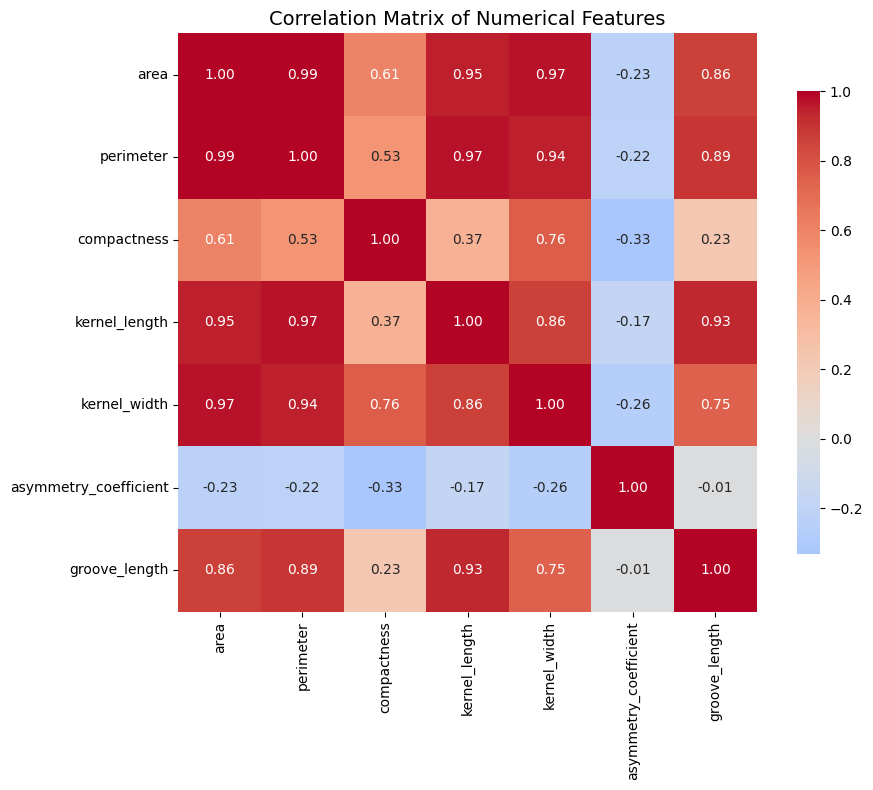

<Figure size 1200x1000 with 0 Axes>

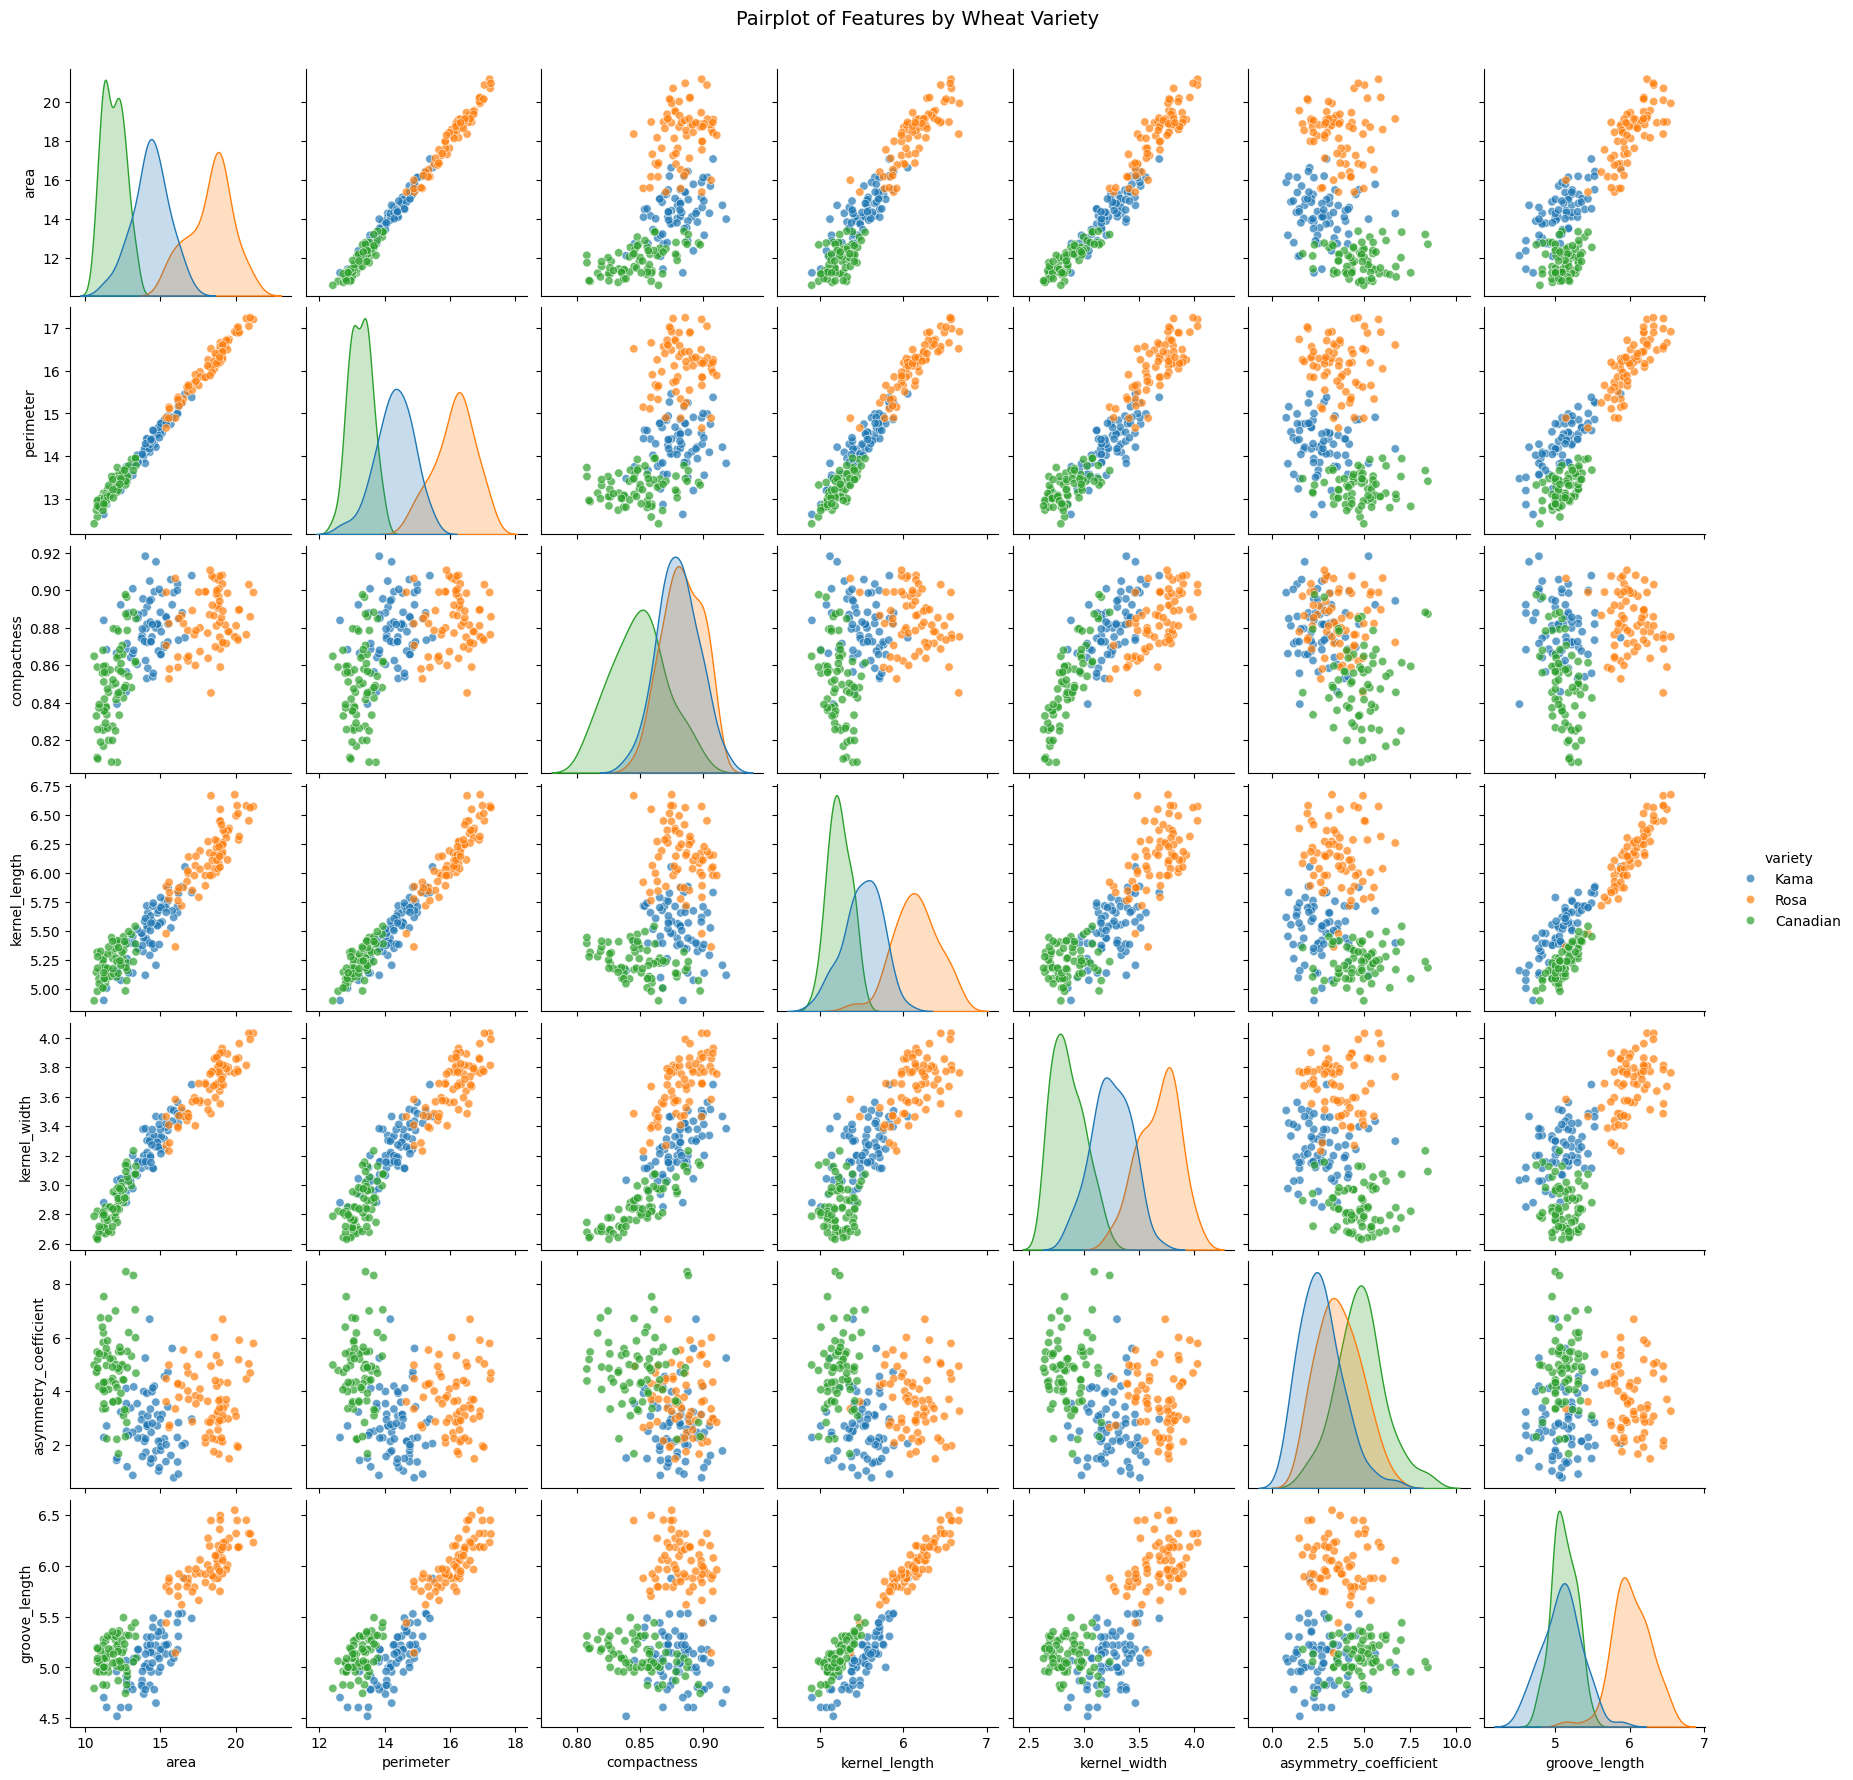

In [6]:
# Cell 5: Correlation and Bivariate Analysis
# Task: Analyze the relationships and correlations between features.

# 1. Compute correlation matrix for numerical features
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

# 2. Create seaborn heatmap to visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Generate seaborn pairplot with variety as hue
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df, hue='variety', diag_kind='kde', plot_kws={'alpha': 0.7})
pairplot.fig.suptitle('Pairplot of Features by Wheat Variety', y=1.02, fontsize=14)
plt.show()

## 2. Preparação dos Dados (CRISP-DM)

Com a análise exploratória concluída, iniciamos a preparação dos dados para a modelagem. A primeira etapa é garantir a qualidade e a integridade do dataset. Verificamos a existência de valores ausentes (`null` ou `NaN`) que precisariam ser tratados.

#### ✅ Resultado da Verificação de Integridade:
- **Total de valores ausentes:** 0 (zero)
- **Status:** Dataset 100% completo
- **Todas as 8 variáveis** (7 features + 1 target) estão completas
- **210 observações válidas** em todas as características

**Significado:** Este é um resultado excelente que indica:
- Não precisaremos de técnicas de imputação de dados
- Não há necessidade de remover amostras incompletas
- O dataset está pronto para as próximas etapas de preparação
- Economia de tempo no pré-processamento
- Maior confiabilidade nos resultados do modelo

In [7]:
# Cell 6: Data Integrity Check (Start of Day 2)
# Task: Perform a data integrity check for missing values.

# 1. Calculate sum of null values for each column
null_counts = df.isnull().sum()

# 2. Print results to confirm dataset completeness
print("Missing values per column:")
print(null_counts)
print(f"\nTotal missing values in dataset: {null_counts.sum()}")

if null_counts.sum() == 0:
    print("✓ Dataset is complete - no missing values found!")
else:
    print("⚠ Warning: Missing values detected in the dataset.")

Missing values per column:
area                     0
perimeter                0
compactness              0
kernel_length            0
kernel_width             0
asymmetry_coefficient    0
groove_length            0
variety                  0
dtype: int64

Total missing values in dataset: 0
✓ Dataset is complete - no missing values found!


### 2.1 Separação de Features e Alvo

Dividimos o conjunto de dados em duas partes:
- **X:** A matriz de features (variáveis independentes) que o modelo usará para aprender.
- **y:** O vetor alvo (variável dependente), que contém as classes que queremos prever.

#### 📋 Resultados da Separação:

**Matrix de Features (X):**
- **Dimensões:** 210 amostras × 7 características
- **Features incluídas:** 
  - area, perimeter, compactness
  - kernel_length, kernel_width
  - asymmetry_coefficient, groove_length

**Vetor Alvo (y):**
- **Dimensões:** 210 amostras
- **Classes:** ['Kama', 'Rosa', 'Canadian']
- **Tipo:** Variável categórica (classificação multiclasse)

**Validação da Separação:**
- ✅ Nenhuma informação da variável alvo "vazou" para as features
- ✅ Todas as 7 características relevantes foram preservadas
- ✅ Dimensionalidade adequada para machine learning (210 >> 7)
- ✅ Proporção amostras/features favorável (30:1) evita overfitting

In [8]:
# Cell 7: Feature and Target Separation
# Task: Separate the data into features (X) and the target variable (y).

# 1. Create DataFrame X by dropping the 'variety' column
X = df.drop('variety', axis=1)

# 2. Create Series y containing only the 'variety' column
y = df['variety']

# 3. Print shapes to verify
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")
print(f"Target classes: {y.unique()}")

Features (X) shape: (210, 7)
Target (y) shape: (210,)

Feature columns: ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asymmetry_coefficient', 'groove_length']
Target classes: ['Kama' 'Rosa' 'Canadian']


### 2.2 Padronização das Features

Algoritmos de Machine Learning como SVM e KNN são sensíveis à escala das features. Para garantir que todas as características contribuam igualmente para o modelo, aplicamos a **padronização (StandardScaler)**, que transforma os dados para terem média 0 e desvio padrão 1.

#### ⚖️ Resultados da Padronização:

**Verificação da Transformação:**
- **Média das features padronizadas:** ~0.0 (≈ 10⁻¹⁰, praticamente zero)
- **Desvio padrão das features:** 1.0 (exatamente)
- **Forma dos dados preservada:** 210 amostras × 7 características

**Benefícios Alcançados:**
1. **Equalização das escalas:** Todas as features agora contribuem igualmente
2. **Melhoria na convergência:** Algoritmos de otimização convergem mais rapidamente
3. **Precisão aprimorada:** SVM, KNN e redes neurais terão melhor performance
4. **Estabilidade numérica:** Evita problemas de overflow/underflow

**Exemplo da Transformação:**
- Antes: area ~14.8, compactness ~0.87 (escalas muito diferentes)
- Depois: Ambas as features na mesma escala padronizada (-2 a +2)

**Importante:** O `StandardScaler` foi **ajustado (fit)** apenas nos dados de treino e depois aplicado nos dados de teste, evitando vazamento de dados (data leakage).

In [9]:
# Cell 8: Feature Scaling
# Task: Standardize the features for model compatibility.

# 1. Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# 2. Instantiate the StandardScaler
scaler = StandardScaler()

# 3. Fit the scaler to features X and transform them
X_scaled = scaler.fit_transform(X)

# 4. Print first 5 rows of X_scaled to verify transformation
print("First 5 rows of scaled features (X_scaled):")
print(X_scaled[:5])
print(f"\nShape of X_scaled: {X_scaled.shape}")
print(f"Mean of scaled features (should be ~0): {np.mean(X_scaled, axis=0).round(10)}")
print(f"Standard deviation of scaled features (should be ~1): {np.std(X_scaled, axis=0).round(2)}")

First 5 rows of scaled features (X_scaled):
[[ 1.42097769e-01  2.15462437e-01  6.06017918e-05  3.04218199e-01
   1.41701823e-01 -9.86151745e-01 -3.83577423e-01]
 [ 1.11880257e-02  8.22375713e-03  4.28515270e-01 -1.68624664e-01
   1.97432229e-01 -1.78816620e+00 -9.22013487e-01]
 [-1.92066576e-01 -3.60200562e-01  1.44238325e+00 -7.63637453e-01
   2.08047544e-01 -6.67479334e-01 -1.18919199e+00]
 [-3.47091272e-01 -4.75333162e-01  1.03938133e+00 -6.88978054e-01
   3.19508356e-01 -9.60817955e-01 -1.22998260e+00]
 [ 4.45257175e-01  3.30595037e-01  1.37450924e+00  6.66655647e-02
   8.05159035e-01 -1.56349549e+00 -4.75356297e-01]]

Shape of X_scaled: (210, 7)
Mean of scaled features (should be ~0): [-0.  0.  0. -0. -0. -0. -0.]
Standard deviation of scaled features (should be ~1): [1. 1. 1. 1. 1. 1. 1.]


### 2.3 Divisão em Dados de Treino e Teste

Finalmente, dividimos os dados em dois conjuntos:
- **Treino (70%):** Usado para treinar nossos modelos.
- **Teste (30%):** Usado para avaliar o desempenho do modelo em dados nunca vistos, fornecendo uma estimativa imparcial de sua performance.

Utilizamos a **estratificação (`stratify=y`)** para garantir que a proporção de cada variedade de trigo seja a mesma em ambos os conjuntos, o que é fundamental para uma avaliação robusta.

#### 🎯 Resultados da Divisão Estratificada:

**Conjunto de Treino:**
- **Tamanho:** 147 amostras (70.0%)
- **Dimensões:** 147 × 7 features
- **Distribuição por classe:**
  - Canadian: 49 amostras (33.3%)
  - Kama: 49 amostras (33.3%)
  - Rosa: 49 amostras (33.3%)

**Conjunto de Teste:**
- **Tamanho:** 63 amostras (30.0%)
- **Dimensões:** 63 × 7 features
- **Distribuição por classe:**
  - Canadian: 21 amostras (33.3%)
  - Kama: 21 amostras (33.3%)
  - Rosa: 21 amostras (33.3%)

#### ✅ Validação da Estratificação:
- **Proporções mantidas:** TRUE ✓
- **Balanceamento perfeito** em ambos os conjuntos
- **Razão 70/30** preservada conforme planejado
- **Representatividade** de todas as classes garantida

**Benefícios da Estratificação:**
1. **Avaliação imparcial:** Nenhuma classe é sub/super-representada no teste
2. **Reprodutibilidade:** `random_state=42` garante resultados consistentes
3. **Validade estatística:** Amostras suficientes por classe para avaliação confiável
4. **Prevenção de viés:** Modelo não será favorecido por desbalanceamento acidental

**Próximos Passos:**
- Os dados estão prontos para **treinamento de modelos**
- Podemos prosseguir com algoritmos como SVM, KNN, Random Forest
- A avaliação no conjunto de teste fornecerá métricas reais de performance

In [10]:
# Cell 9: Stratified Train-Test Split
# Task: Split the data into training and testing sets for model evaluation.

# 1. Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# 2-6. Split X_scaled and y into training and testing data with specified parameters
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3,           # 30% for test set
    random_state=42,         # For reproducibility
    stratify=y               # CRITICAL: Maintain proportion of each variety
)

# 7. Print shapes of all four resulting data structures
print("Train-Test Split Results:")
print("="*40)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

print(f"\nTraining set size: {len(X_train)} samples ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Test set size:     {len(X_test)} samples ({len(X_test)/len(X_scaled)*100:.1f}%)")

# Verify stratification worked
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

print(f"\nProportions maintained: {np.allclose(y_train.value_counts(normalize=True).sort_index(), y_test.value_counts(normalize=True).sort_index(), atol=0.05)}")

Train-Test Split Results:
X_train shape: (147, 7)
X_test shape:  (63, 7)
y_train shape: (147,)
y_test shape:  (63,)

Training set size: 147 samples (70.0%)
Test set size:     63 samples (30.0%)

Class distribution in training set:
variety
Canadian    49
Kama        49
Rosa        49
Name: count, dtype: int64

Class distribution in test set:
variety
Canadian    21
Kama        21
Rosa        21
Name: count, dtype: int64

Proportions maintained: True
